In [1]:

import xarray
import pandas as pd
import numpy as np
from datetime import datetime
from glob import glob
from tqdm import tqdm
import os

In [2]:
def bad_lines(bad_line):
    new_line = bad_line[:7] + [' '.join(bad_line[7:])]
    return new_line # concat names where there is white space within the name, could mess up some names but unimportant

station_info = pd.read_csv('DWD/zehn_min_sd_Beschreibung_Stationen.txt', 
                           delim_whitespace=True, 
                           header=0, 
                           names=['station_id', 'start_date', 'end_date', 'altitude', 'lat', 'lon', 'name', 'bundesland'],
                           index_col='station_id',
                           encoding='latin-1', 
                           engine='python', 
                           on_bad_lines=bad_lines,
                           skiprows=[1])

def parse_date_DWD(x):
    return datetime.strptime(str(x), '%Y%m%d')

def parse_datetimes_DWD(x):
    return datetime.strptime(str(x), '%Y%m%d%H%M')

station_info['start_date'] = station_info.start_date.apply(parse_date_DWD)
station_info['end_date'] = station_info.end_date.apply(parse_date_DWD)
station_info


,start_date,end_date,altitude,lat,lon,name,bundesland
station_id,,,,,,,
3,1993-04-28,2012-04-03,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,2007-04-02,2024-03-13,44,52.9336,8.2370,Großenkneten,Niedersachsen
71,2010-02-16,2020-01-02,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
73,2007-04-12,2023-06-05,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern
131,2004-09-16,2024-03-13,296,51.0881,12.9326,Geringswalde-Altgeringswalde,Sachsen
...,...,...,...,...,...,...,...
13965,2008-10-30,2024-03-13,619,48.2639,8.8134,Balingen-Bronnhaupten,Baden-Württemberg
15000,2011-03-11,2024-03-13,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen
15207,2013-11-01,2024-03-13,317,51.2835,9.3590,Schauenburg-Elgershausen,Hessen


In [114]:

def read_DWD_csv(fn):
    df = pd.read_csv(fn, 
                sep='\s*;\s*', 
                na_values=[-999, '-999'],
                engine='python',
                dtype={'QN':np.int8,
                       'DS_10':np.float32,
                       'GS_10': np.float32,
                       'SD_10': np.float32,
                       'LS_10': np.float32,
                       })
    df = df.drop(columns=['STATIONS_ID']).dropna(axis='index', how='all', subset=['DS_10', 'GS_10']) # if diffuse or Global radiation not found drop record
    if 'eor' in df.columns:
        df = df.drop(columns=['eor'])
    df['MESS_DATUM'] = df.MESS_DATUM.apply(parse_datetimes_DWD)
    df = df.set_index('MESS_DATUM')
    df = df.rename(columns={'STATIONS_ID': 'station_id'})
    df.index = df.index.rename('time')
    return df

df = read_DWD_csv('/home/kr/Documents/Solar_Power_Forecasting/03_ground_stations/DWD/10minutenwerte_SOLAR_15444_20200101_20221231_hist.zip')
xar = df.to_xarray()
xar

<xarray.Dataset>
Dimensions:  (time: 9430)
Coordinates:
  * time     (time) datetime64[ns] 2022-10-27T12:20:00 ... 2022-12-31T23:50:00
Data variables:
    QN       (time) int8 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3 3
    DS_10    (time) float32 3.4 3.3 3.3 3.3 3.2 3.1 ... 0.0 0.0 0.0 0.0 0.0 0.0
    GS_10    (time) float32 26.5 25.8 25.0 24.2 23.3 ... 0.0 0.0 0.0 0.0 0.0
    SD_10    (time) float32 0.167 0.167 0.167 0.167 0.167 ... 0.0 0.0 0.0 0.0
    LS_10    (time) float32 18.7 18.8 18.8 18.8 18.8 ... 19.0 19.0 19.0 18.8

In [111]:
ser = station_info.loc[15444]

xar = xar.assign_coords(coords={'lat':ser.lat, 'lon':ser.lon, 'elevation':ser.altitude})
xar = xar.assign_attrs( {'provider': 'DWD', 'station_id':15444, 'name':ser.name, 'bundes land':ser.bundesland, 'start_date':ser.start_date, 'end_date':ser.end_date})
xar['QN'] = xar.QN.assign_attrs({'standard_name' : 'quality_level',
                           'long_name': 'Quality Level',
                           'abbreviation': 'QN',
                           '_valid_min':0,
                           '_valid_max':3,
                           })
for var, (nm1, nm2) in zip(['DS_10', 'GS_10', 'SD_10', 'LS_10'], 
                           [['sum_diffuse_sky_radiation', 'sum of diffuse sky radiation during the previous 10 minutes'], 
                            ['sum_global_sky_radiation', 'sum of global radiation during the previous 10 minutes'],
                            ['sum_sunshine_duration', 'sum of sunshine duration during the previous 10 minutes'],
                            ['sum_longwave_sky_radiation', 'sum of longwave radiation during the previous 10 minutes']]):
    if var == 'SD_10':
        xar[var] = xar[var].assign_attrs({
            'long_name' : nm1 ,
            'standard_name' : nm2,
            'units' : 'h',
        })
    else:
        xar[var] = xar[var].assign_attrs({
            'long_name' : nm1 ,
            'standard_name' : nm2,
            'units' : 'J cm-2',
        })


xar

# xar.to_netcdf('/home/kr/Documents/Solar_Power_Forecasting/03_ground_stations/DWD/netcdf/DWD_SOLAR_10min_15444.nc')

<xarray.Dataset>
Dimensions:    (time: 9430)
Coordinates:
  * time       (time) datetime64[ns] 2022-10-27T12:20:00 ... 2022-12-31T23:50:00
    lat        float64 48.44
    lon        float64 9.922
    elevation  int64 593
Data variables:
    QN         (time) int8 3 3 3 3 3 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3 3 3 3 3
    DS_10      (time) float32 3.4 3.3 3.3 3.3 3.2 3.1 ... 0.0 0.0 0.0 0.0 0.0
    GS_10      (time) float32 26.5 25.8 25.0 24.2 23.3 ... 0.0 0.0 0.0 0.0 0.0
    SD_10      (time) float32 0.167 0.167 0.167 0.167 0.167 ... 0.0 0.0 0.0 0.0
    LS_10      (time) float32 18.7 18.8 18.8 18.8 18.8 ... 19.0 19.0 19.0 18.8
Attributes:
    provider:     DWD
    station_id:   15444
    name:         15444
    bundes land:  Baden-Württemberg
    start_date:   2014-08-14 00:00:00
    end_date:     2024-03-13 00:00:00

In [122]:
SAVE_PATH = '/home/kr/Documents/Solar_Power_Forecasting/03_ground_stations/DWD/netcdf/'

processed = []

for id in tqdm(station_info.index.unique()):
    fns = glob(f'DWD/10minutenwerte_SOLAR_{str(id).zfill(5)}*')

    if len(fns) == 0:
        continue
    elif os.path.exists(SAVE_PATH + f'DWD_SOLAR_10min_{str(id).zfill(5)}.nc'):
        processed.append(id)
        'already processed'
        continue

    dfs = [read_DWD_csv(fn) for fn in fns]
    df = pd.concat(dfs)
    if len(df) <100:
        continue # do not bother when there is no record

    xar = df.to_xarray()

    series = station_info.loc[id]
    xar = xar.assign(station_name=f'DWD_{str(id).zfill(5)}')
    xar = xar.assign_coords(coords={'lat':series.lat, 'lon':series.lon, 'elevation':series.altitude})
    xar = xar.assign_attrs( {'provider': 'DWD', 
                             'station_id':id, 
                             'name':series.name, 
                             'bundesland':series.bundesland, 
                             'start_date':series.start_date.isoformat(), 
                             'end_date':ser.end_date.isoformat()})
    xar['QN'] = xar.QN.assign_attrs({'standard_name' : 'quality_level',
                            'long_name': 'Quality Level',
                            'abbreviation': 'QN',
                            '_valid_min':0,
                            '_valid_max':3,
                            })
    for var, (nm1, nm2) in zip(['DS_10', 'GS_10', 'SD_10', 'LS_10'], 
                           [['sum_diffuse_sky_radiation', 'sum of diffuse sky radiation during the previous 10 minutes'], 
                            ['sum_global_sky_radiation', 'sum of global radiation during the previous 10 minutes'],
                            ['sum_sunshine_duration', 'sum of sunshine duration during the previous 10 minutes'],
                            ['sum_longwave_sky_radiation', 'sum of longwave radiation during the previous 10 minutes']]):
        if var == 'SD_10':
            xar[var] = xar[var].assign_attrs({
                'long_name' : nm1 ,
                'standard_name' : nm2,
                'units' : 'h',
            })
        else:
            xar[var] = xar[var].assign_attrs({
                'long_name' : nm1 ,
                'standard_name' : nm2,
                'units' : 'J cm-2',
            })
    
    xar.to_netcdf(SAVE_PATH + f'DWD_SOLAR_10min_{str(id).zfill(5)}.nc')
    processed.append(id)


print(f'processed: {len(processed)}')    

 22%|██▏       | 70/325 [02:25<20:14,  4.76s/it]/tmp/ipykernel_6815/1365641526.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat(dfs)
 22%|██▏       | 72/325 [02:48<35:08,  8.33s/it]/tmp/ipykernel_6815/1365641526.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat(dfs)
 22%|██▏       | 73/325 [02:54<32:41,  7.79s/it]/tmp/ipykernel_6815/1365641526.py:15: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the res

processed: 141


In [17]:
fns = glob('DWD/netcdf/DWD_SOLAR_10min_*.nc')
processed = [int(fn.split('_')[-1].split('.')[0])for fn in fns]

index = station_info.loc[processed].to_xarray()
index = index.set_coords(['lat', 'lon', 'altitude'])
index.to_netcdf('DWD/netcdf/DWD_SOLAR_index.nc')
index

<xarray.Dataset>
Dimensions:     (station_id: 141)
Coordinates:
  * station_id  (station_id) int64 3287 891 3231 3023 ... 5856 3811 4393 4625
    altitude    (station_id) int64 453 5 450 22 12 167 565 ... 4 85 476 150 5 59
    lat         (station_id) float64 49.72 53.87 50.56 ... 51.3 54.33 53.64
    lon         (station_id) float64 9.1 8.706 10.38 7.308 ... 13.09 8.603 11.39
Data variables:
    start_date  (station_id) datetime64[ns] 1991-01-01 1999-04-28 ... 1992-03-27
    end_date    (station_id) datetime64[ns] 2024-03-13 2024-03-13 ... 2023-09-27
    name        (station_id) object 'Michelstadt-Vielbrunn' ... 'Schwerin'
    bundesland  (station_id) object 'Hessen' ... 'Mecklenburg-Vorpommern'

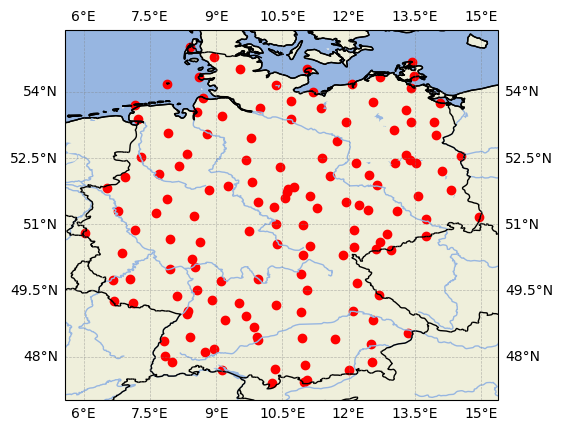

In [49]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection=proj))

axis.coastlines()
gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5, linestyle='--')
axis.add_feature(cfeature.LAND)
axis.add_feature(cfeature.COASTLINE)
axis.add_feature(cfeature.LAKES)
axis.add_feature(cfeature.OCEAN)
axis.add_feature(cfeature.RIVERS)
axis.add_feature(cfeature.BORDERS)



lat = index.lat.values
lon = index.lon.values
# axis.set_extent([min(lon)-1, max(lon)+1, min(lat)-1, max(lat)+1])
name = index.station_id.values
axis.scatter(x=lon, y=lat, c='r')
# for i, txt in enumerate(name):
#     axis.annotate(txt, (lon[i], lat[i]))

fig.savefig('index.png')